In [ ]:
%load_ext autoreload
%autoreload 2


In [3]:
! pip install polars

Defaulting to user installation because normal site-packages is not writeable
  Using cached polars-1.35.2-py3-none-any.whl.metadata (10 kB)
  Using cached polars_runtime_32-1.35.2-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.5 kB)
Using cached polars-1.35.2-py3-none-any.whl (783 kB)
Using cached polars_runtime_32-1.35.2-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (41.3 MB)


In [2]:
import polars as pl
import matplotlib.pyplot as plt
from primary.preprocessing import cluster_purity, particle_purity
import plotly.express as px
import numpy as np
from primary.pdg_mappings import PDG_ID_TO_NAME

import numpy as np
import plotly.graph_objects as go
import ipywidgets as widgets
from collections import defaultdict, deque

/usr/wipp/conda/24.5.0u/envs/common/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:11: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.3)
  from scipy.sparse import csr_matrix, issparse


In [37]:
from huggingface_hub import HfFileSystem
import polars as pl

fs = HfFileSystem()


with fs.open("datasets/OpenDataDetector/ColliderML-Release-1/data/ttbar_pu0_particles/train-00000-of-00100.parquet", "rb") as f:
    particles = pl.read_parquet(f)

with fs.open("datasets/OpenDataDetector/ColliderML-Release-1/data/ttbar_pu0_calo_hits/train-00000-of-00100.parquet", "rb") as f:
    calo_hits = pl.read_parquet(f)

with fs.open("datasets/OpenDataDetector/ColliderML-Release-1/data/ttbar_pu0_tracks/train-00000-of-00100.parquet", "rb") as f:
    tracks = pl.read_parquet(f)


In [38]:
from primary.preprocessing import add_orphan_mask, cast_parent_id_to_int64,add_created_inside_calo_mask, add_particle_have_track_mask,add_eta_and_phi,get_particles_id_parent_of_inside_calo_particles_mask
from primary.preprocessing import set_target_particles_mask
from primary.preprocessing import get_particles_id_parent_of_inside_calo_particles_maskv2
#particles = cast_parent_id_to_int64(particles)
particles = add_orphan_mask(particles)
particles = add_created_inside_calo_mask(particles)
particles = add_particle_have_track_mask(particles, tracks)
particles = add_eta_and_phi(particles)
particles = get_particles_id_parent_of_inside_calo_particles_maskv2(particles, calo_hits)
particles = set_target_particles_mask(particles)
particles


Computing parent existence mask...
Preparing lineage map...
Converged after 5 iterations.


event_id,is_target_particle,enter_calo,has_track,particle_id,pdg_id,mass,energy,charge,vx,vy,vz,time,px,py,pz,perigee_d0,perigee_z0,vertex_primary,parent_id,primary,is_parent_missing,created_inside_calo,eta,phi,pt
u32,list[bool],list[bool],list[bool],list[u64],list[i64],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[u16],list[i64],list[bool],list[bool],list[bool],list[f32],list[f32],list[f32]
649,"[true, false, … true]","[false, false, … false]","[false, false, … false]","[19, 20, … 4409]","[-213, 2224, … -11]","[0.915503, 1.209991, … 0.000511]","[1501.457886, 4882.183594, … 22.920151]","[-1.0, 2.0, … 1.0]","[-0.017771, -0.017771, … -16.878029]","[-0.003283, -0.003283, … -17.527498]","[-52.440014, -52.440014, … 2722.586182]","[0.297145, 0.297145, … 9.553991]","[0.15656, -0.15656, … -0.136922]","[0.277704, -0.277704, … -0.141287]","[1501.45752, 4882.183105, … 22.919306]","[NaN, NaN, … NaN]","[NaN, NaN, … NaN]","[1, 1, … 1]","[9, 9, … 4407]","[true, true, … false]","[true, true, … false]","[false, false, … false]","[9.150546, 10.329702, … 5.450978]","[1.057446, -2.084146, … -2.340506]","[0.318795, 0.318795, … 0.196748]"
387,"[false, false, … true]","[false, false, … false]","[false, false, … false]","[104, 105, … 9594]","[213, -211, … 22]","[0.735179, 0.13957, … 0.0]","[118.035141, 49.929668, … 9.478293]","[1.0, -1.0, … 0.0]","[-0.018042, -0.018042, … 24.540348]","[0.018347, 0.018347, … 44.978424]","[92.717186, 92.717186, … -1320.670776]","[0.010941, 0.010941, … 4.728593]","[1.726296, 0.712598, … 0.152364]","[4.516778, 1.302677, … 0.311263]","[-117.933762, -49.907391, … -9.471955]","[0.023403, 0.024633, … -2.266319]","[92.978065, 92.967155, … 78.375572]","[1, 1, … 1]","[7, 7, … 9590]","[true, true, … false]","[true, true, … false]","[false, false, … false]","[-3.887719, -4.208232, … -4.001538]","[1.205732, 1.07024, … 1.115582]","[4.83543, 1.484844, … 0.346554]"
908,"[false, false, … false]","[true, false, … false]","[false, false, … false]","[45, 46, … 7685]","[-321, 211, … 2112]","[0.49368, 0.13957, … 0.939565]","[2.897977, 1.741386, … 0.940269]","[-1.0, 1.0, … 0.0]","[-0.005302, -0.005302, … -98.723488]","[0.026734, 0.026734, … 1188.084106]","[86.26033, 86.26033, … 1222.162964]","[0.020885, 0.020885, … 116.923576]","[0.211317, 0.081697, … 0.015491]","[0.426406, -0.510454, … -0.029156]","[2.815683, 1.657018, … 0.015238]","[0.016622, -0.001011, … 470.260742]","[86.132538, 86.347633, … 1727.78186]","[1, 1, … 1]","[9, 9, … 7663]","[true, true, … false]","[true, true, … false]","[false, false, … false]","[2.477974, 1.881465, … 0.446548]","[1.110695, -1.412095, … -1.082417]","[0.475896, 0.51695, … 0.033016]"
652,"[false, false, … false]","[true, false, … false]","[false, false, … false]","[57, 58, … 5277]","[-313, -211, … 11]","[0.908738, 0.13957, … 0.000511]","[4.229085, 11.952354, … 0.00052]","[0.0, -1.0, … -1.0]","[0.005982, 0.005982, … 194.004669]","[0.001853, 0.001853, … 494.204834]","[-21.549875, -21.549875, … 1557.38562]","[0.064334, 0.064334, … 6.291512]","[-0.07758, 0.659941, … -0.00009]","[-0.338812, 1.110471, … -0.000028]","[4.115646, 11.881525, … -0.000003]","[0.005418, -0.004196, … NaN]","[-21.512682, -21.592632, … NaN]","[1, 1, … 1]","[7, 7, … 5276]","[true, true, … false]","[true, true, … false]","[false, false, … false]","[3.16648, 2.915061, … -0.033526]","[-1.795892, 1.034586, … -2.837505]","[0.347581, 1.29177, … 0.000094]"
393,"[false, false, … false]","[true, true, … false]","[false, false, … false]","[65, 66, … 6797]","[-211, 211, … 2212]","[0.13957, 0.13957, … 0.938272]","[8.791349, 3.546382, … 1.217234]","[-1.0, 1.0, … 1.0]","[-0.002553, -0.002553, … 1541.634399]","[-0.00393, -0.00393, … 961.824402]","[43.09972, 43.09972, … 27.119455]","[0.018686, 0.018686, … 6.474351]","[8.038111, 3.383335, … -0.137164]","[3.534456, 0.903935, … 0.680441]","[0.405885, -0.541562, … 0.345674]","[-0.00257, -0.003138, … -1701.298462]","[43.099899, 43.0991

In [ ]:
from primary.preprocessing import map_calo_depositors_to_first_outside_ancestor
lineage = map_calo_depositors_to_first_outside_ancestor(particles, calo_hits)


SyntaxError: incomplete input (3664954349.py, line 3)

In [ ]:
(lineage.lazy()
.join(particles.lazy()
      .select('event_id','particle_id','created_inside_calo')
      .explode('particle_id','created_inside_calo')
      
,left_on=['event_id','ancestor_outside_calo_id'],
right_on=['event_id','particle_id'],
how='inner')

).collect(streaming=True)

/tmp/ipykernel_883149/3735302246.py:10: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  ).collect(streaming=True).filter(pl.col('created_inside_calo')==False).count()


event_id,particle_id,ancestor_outside_calo_id,created_inside_calo
u32,u32,u32,u32
4099408,4099408,4099408,4099408


In [ ]:
(
    particles.lazy()
    .select(['particle_id', 'parent_id', 'event_id','has_track'])
    .
)

/tmp/ipykernel_883149/401062618.py:22: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  .collect(streaming=True)


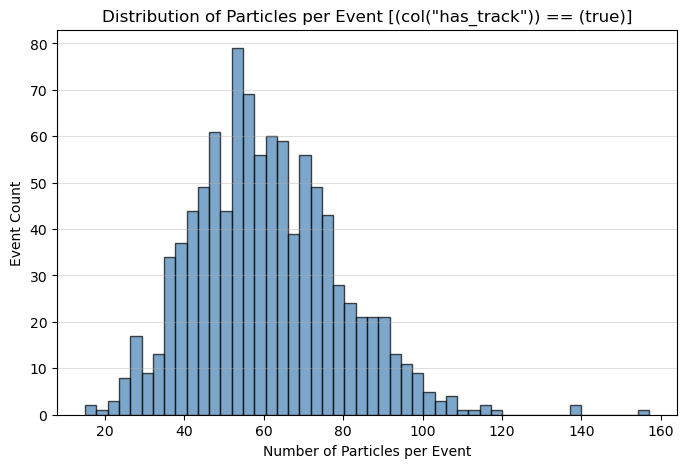

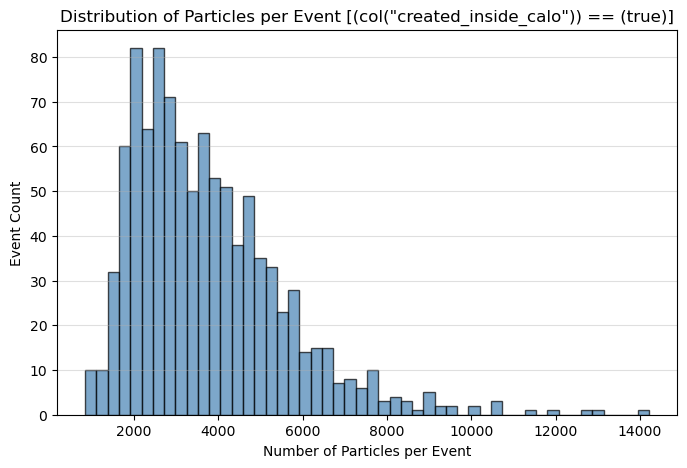

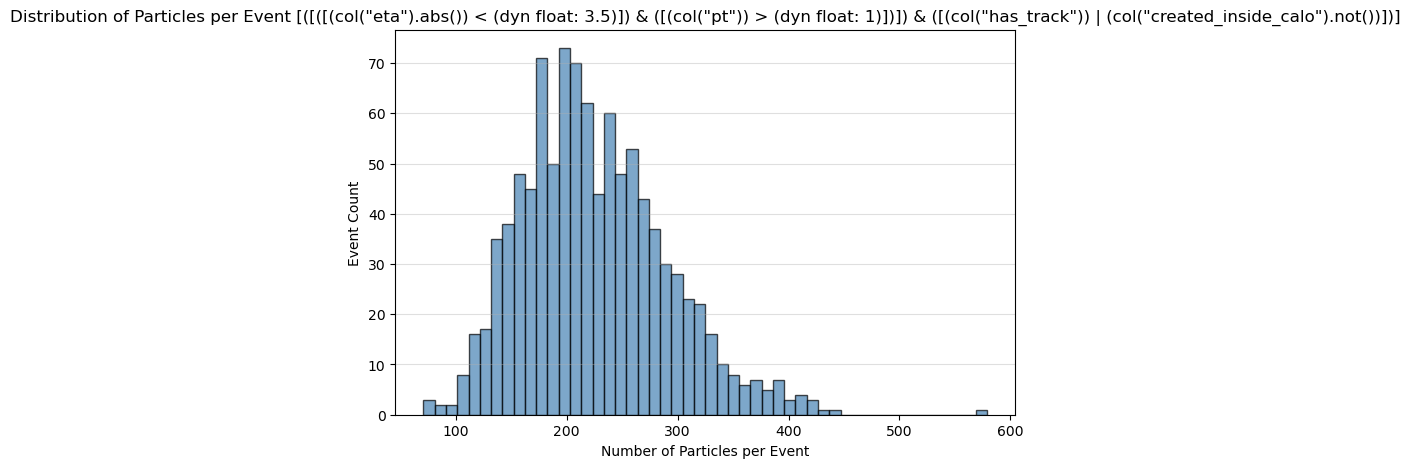

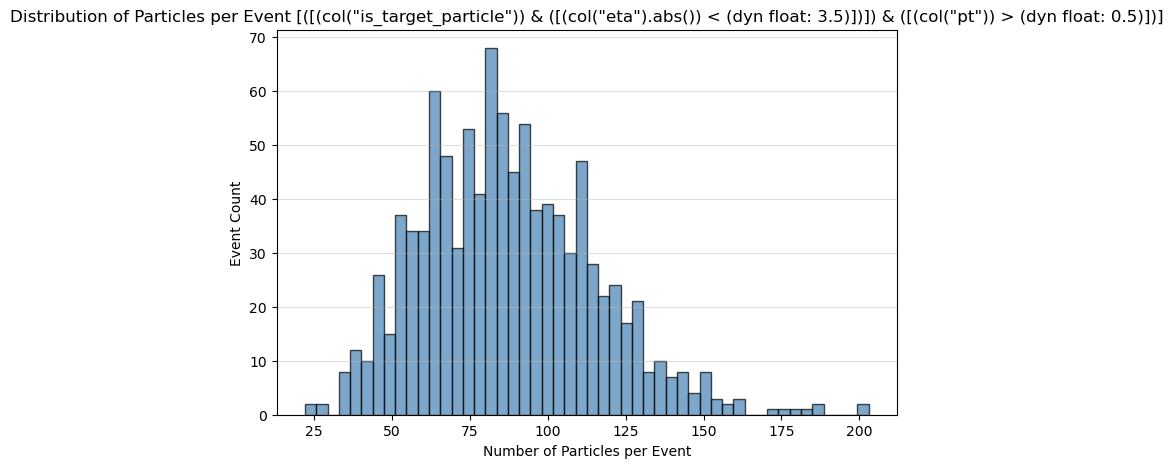

In [39]:
# ...existing code..
# def .
def plot_particle_counts_histogram(p: pl.DataFrame, expr: pl.Expr) -> None:
    particle_counts = (
        p.lazy()
        .select([
            pl.col("particle_id"),
            pl.col("event_id"),
            pl.col("created_inside_calo"),
            pl.col("is_parent_missing"),
            pl.col("eta"),
            pl.col("has_track"),
            pl.col("pt"),
            pl.col('enter_calo'),
            pl.col('is_target_particle')
        ])
        .explode("created_inside_calo", "has_track", 'particle_id', 'is_parent_missing', "eta", "pt", 'enter_calo', 'is_target_particle')
        .filter(expr)
        .drop("has_track", "created_inside_calo", 'particle_id', 'is_parent_missing', "eta", "pt",'enter_calo', 'is_target_particle')
        .group_by("event_id")
        .len()
        .collect(streaming=True)
    )

    counts = particle_counts["len"].to_numpy()

    plt.figure(figsize=(8, 5))
    plt.hist(counts, bins=50, color="steelblue", edgecolor="black", alpha=0.7)
    plt.xlabel(f"Number of Particles per Event")
    plt.ylabel("Event Count")
    plt.title(f"Distribution of Particles per Event {expr}")
    plt.grid(axis="y", alpha=0.4)
    plt.show()
# ...existing code...

plot_particle_counts_histogram(particles, pl.col("has_track") == True)
plot_particle_counts_histogram(particles, pl.col("created_inside_calo") == True)
plot_particle_counts_histogram(particles, (pl.col("eta").abs() < 3.5) & 
                                (pl.col("pt") > 1.0   ) &
                               (pl.col("has_track") | ~pl.col("created_inside_calo")))
plot_particle_counts_histogram(particles, pl.col('is_target_particle') &(pl.col("eta").abs() < 3.5) & 
                                (pl.col("pt") > 0.5   ) )


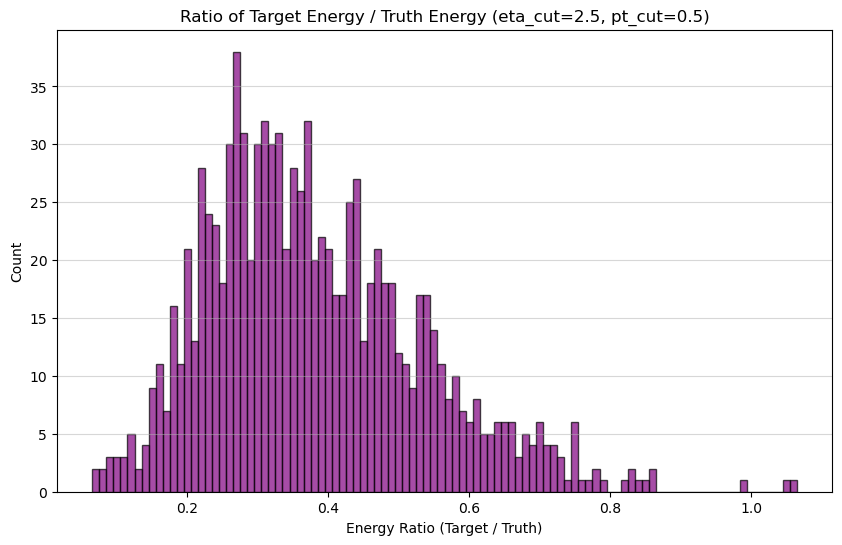

In [ ]:
from primary.plot import plot_target_vs_truth_energy_sum
plot_target_vs_truth_energy_sum(particles,eta_cut=3.5, pt_cut=0.5)


In [53]:
particles

event_id,is_target_particle,enter_calo,has_track,enter_calo_right,has_track_right,particle_id,pdg_id,mass,energy,charge,vx,vy,vz,time,px,py,pz,perigee_d0,perigee_z0,vertex_primary,parent_id,primary,created_inside_calo,eta,phi,pt,is_parent_missing,created_inside_calo_right,eta_right,phi_right,pt_right
u32,list[bool],list[bool],list[bool],list[bool],list[bool],list[u64],list[i64],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[u16],list[i64],list[bool],list[bool],list[f32],list[f32],list[f32],list[bool],list[bool],list[f32],list[f32],list[f32]
652,"[false, true, … false]","[false, false, … false]","[false, false, … false]","[false, false, … false]","[true, false, … false]","[57, 58, … 5277]","[-313, -211, … 11]","[0.908738, 0.13957, … 0.000511]","[4.229085, 11.952354, … 0.00052]","[0.0, -1.0, … -1.0]","[0.005982, 0.005982, … 194.004669]","[0.001853, 0.001853, … 494.204834]","[-21.549875, -21.549875, … 1557.38562]","[0.064334, 0.064334, … 6.291512]","[-0.07758, 0.659941, … -0.00009]","[-0.338812, 1.110471, … -0.000028]","[4.115646, 11.881525, … -0.000003]","[0.005418, -0.004196, … NaN]","[-21.512682, -21.592632, … NaN]","[1, 1, … 1]","[7, 7, … 5276]","[true, true, … false]","[false, false, … false]","[3.16648, 2.915061, … -0.033526]","[-1.795892, 1.034586, … -2.837505]","[0.347581, 1.29177, … 0.000094]","[true, true, … false]","[false, false, … false]","[3.16648, 2.915061, … -0.033526]","[-1.795892, 1.034586, … -2.837505]","[0.347581, 1.29177, … 0.000094]"
250,"[false, false, … false]","[true, true, … false]","[false, false, … false]","[false, false, … false]","[false, false, … false]","[219, 220, … 7359]","[321, -311, … 211]","[0.49368, 0.49761, … 0.13957]","[510.153564, 525.826233, … 0.29946]","[1.0, 0.0, … 1.0]","[0.000895, 0.000895, … -179.946487]","[-0.018766, -0.018766, … 2169.664062]","[59.811329, 59.811329, … -211.217239]","[-0.325794, -0.325794, … 7.330573]","[-0.491808, -0.18692, … -0.203538]","[0.157237, -0.232051, … 0.066429]","[-510.153076, -525.825928, … 0.156064]","[NaN, 0.0, … -2006.760986]","[NaN, 0.0, … -826.59314]","[1, 1, … 1]","[9, 9, … 7358]","[true, true, … false]","[false, false, … true]","[-7.588975, -8.168946, … 0.676194]","[2.832151, -2.248888, … 2.826122]","[0.516332, 0.297971, … 0.214104]","[true, true, … false]","[false, false, … true]","[-7.588975, -8.168946, … 0.676194]","[2.832151, -2.248888, … 2.826122]","[0.516332, 0.297971, … 0.214104]"
256,"[false, false, … false]","[false, false, … false]","[false, false, … false]","[false, false, … false]","[false, false, … false]","[37, 38, … 9647]","[211, 223, … 11]","[0.13957, 0.787747, … 0.000511]","[376.100769, 846.893311, … 0.125725]","[1.0, 0.0, … -1.0]","[-0.029784, -0.029784, … -393.848755]","[-0.012256, -0.012256, … 1251.669922]","[-73.520294, -73.520294, … -2848.599365]","[-0.134761, -0.134761, … 10.227237]","[-0.478596, 0.93805, … -0.025176]","[0.234532, -0.513545, … -0.10697]","[376.100372, 846.892212, … -0.061075]","[NaN, 0.0, … -670.123901]","[NaN, 0.0, … -3475.590332]","[1, 1, … 1]","[10, 10, … 9644]","[true, true, … false]","[false, false, … false]","[7.252291, 7.367602, … -0.530528]","[2.685943, -0.500891, … -1.801943]","[0.532972, 1.069423, … 0.109892]","[true, true, … false]","[false, false, … false]","[7.252291, 7.367602, … -0.530528]","[2.685943, -0.500891, … -1.801943]","[0.532972, 1.069423, … 0.109892]"
518,"[false, false, … false]","[true, false, … false]","[false, false, … false]","[true, false, … false]","[false, false, … false]","[162, 163, … 3964]","[-521, 211, … 11]","[5.27925, 0.13957, … 0.000511]","[50.060131, 4.334189, … 0.374655]","[-1.0, 1.0, … -1.0]","[0.013214, 0.013214, … 1781.001587]","[0.015358, 0.015358, … -23.163168]","[15.136595, 15.136595, … -1129.980835]","[-0.234114, -0.234114, … 6.882857]","[2.405562, 1.052073, … 0.274503]","[5.290852, 0.337904, … -0.020358]","[-49.440533, -4.188637, … -0.254165]","[-0.005673, 0.010581, … NaN]","[15.302

In [9]:
from primary.preprocessing import get_mask_confusion_matrix
get_mask_confusion_matrix(particles, 'primary', 'is_parent_missing')

Comparing 'primary' vs 'is_parent_missing'...

--- Comparison Report: primary vs is_parent_missing ---
Intersection (Both True): 155,285
Only in primary:       218,280
Only in is_parent_missing:       0
Both False:             4,977,711
Both equal (True+False),   5,132,996,percentage: 95.92%
Both true matchinf=g (without both False, both_true / (both_true + a_only + b_only) ,   155,285,percentage: 41.57%
------------------------------


both_true,a_only,b_only,both_false
u32,u32,u32,u32
155285,218280,0,4977711


In [ ]:
get_mask_confusion_matrix((particles.lazy()
                           .select('event_id', 'particle_id','eta', 'pt', 'ener_calo', 'has_track')
                           .explode('pt', 'eta')
                            .filter((pl.col("eta").abs() < 3.5) & 
                                (pl.col("pt") > 0.5  ))
                            .drop('pt', 'eta')

                           ), 'enter_calo', 'has_track', is_lazy=True)

Comparing 'reco' vs 'has_track'...



thread 'polars-0' (405374) panicked at crates/polars-core/src/chunked_array/ops/chunkops.rs:152:13:
Polars' maximum length reached. Consider installing 'polars[rt64]'.
note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace

thread 'polars-2' (405376) panicked at crates/polars-core/src/chunked_array/ops/chunkops.rs:152:13:
Polars' maximum length reached. Consider installing 'polars[rt64]'.


PanicException: Polars' maximum length reached. Consider installing 'polars[rt64]'.

In [16]:
get_mask_confusion_matrix(particles, 'reco', 'is_parent_missing')

Comparing 'reco' vs 'is_parent_missing'...

--- Comparison Report: reco vs is_parent_missing ---
Intersection (Both True): 8,140
Only in reco:       225,913
Only in is_parent_missing:       147,145
Both False:             4,970,078
Both equal (True+False),   4,978,218,percentage: 93.03%
Both true matchinf=g (without both False, both_true / (both_true + a_only + b_only) ,   8,140,percentage: 2.14%
------------------------------


both_true,a_only,b_only,both_false
u32,u32,u32,u32
8140,225913,147145,4970078


In [16]:
from primary.preprocessing import map_to_ultimate_ancestor_with_inherited_mask, map_to_nearest_ancestor_with_track_inherited_mask
particles_with_lineage = map_to_ultimate_ancestor_with_inherited_mask(particles)
particles_with_lineage

Preparing data & calculating masks...
Converged after 5 iterations.
Converged after 5 iterations.


event_id,particle_id,ultimate_ancestor_id,ancestor_created_inside_calo
u32,i64,i64,bool
131,1456,838,false
872,2689,470,false
275,978,365,false
376,8567,992,false
71,1256,673,false
…,…,…,…
234,3148,318,false
361,1261,531,false
975,864,864,false


In [41]:
from primary.preprocessing import map_to_nearest_ancestor_with_track
particle_to_track_linage = map_to_nearest_ancestor_with_track(particles)


Preparing lineage map...
Converged after 5 iterations.
Converged after 5 iterations.


In [ ]:
(
    particles.lazy()
    .select(["event_id", "particle_id", "enter_calo", "has_track"])
    .explode(["particle_id", "enter_calo", "has_track"])
    .filter(pl.col("enter_calo"))
    .join(
        particle_to_track_linage.lazy(),
        left_on=["event_id", "particle_id"],
        right_on=["event_id", "particle_id"],
        how="left"
    )
    .filter(pl.col("ancestor_with_track_id").is_null())
).collect(streaming=True)

/tmp/ipykernel_327862/339866176.py:13: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  ).collect(streaming=True)


event_id,particle_id,enter_calo,has_track,ancestor_with_track_id
u32,u64,bool,bool,i64
122,1158,true,false,null
122,2126,true,false,null
649,847,true,false,null
649,2298,true,false,null
649,2778,true,false,null
…,…,…,…,…
296,3703,true,false,null
296,3869,true,false,null
296,4179,true,false,null


In [38]:
(particles.lazy()
.explode('particle_id', 'has_track')
.filter((pl.col('particle_id') == 424) & (pl.col("event_id") == 122))
.select('event_id', 'particle_id', 'has_track')
).collect(streaming=True)

/tmp/ipykernel_327862/773965513.py:5: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  ).collect(streaming=True)


event_id,particle_id,has_track
u32,u64,bool
122,424,true


In [40]:
(particles.lazy()
 .select('event_id', 'particle_id', 'has_track')
 .explode('particle_id', 'has_track')
 .join(
     particle_to_track_linage.lazy(),
     left_on=['event_id', 'particle_id'],
     right_on=['event_id', 'ancestor_with_track_id'],
     how='inner'
 )
 ).collect(streaming=True)

/tmp/ipykernel_327862/1449636749.py:10: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  ).collect(streaming=True)


event_id,particle_id,has_track,particle_id_right
u32,u64,bool,i64
942,1422,true,1422
942,1784,true,1784
942,1784,true,1786
942,1784,true,1787
942,1784,true,1788
…,…,…,…
556,326,true,878
556,1454,true,1454
556,1454,true,1463


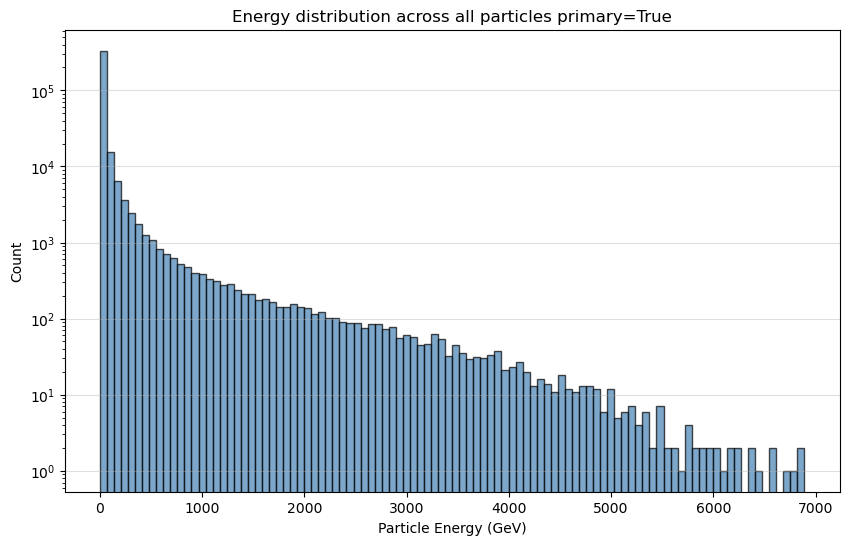

In [16]:
# ...existing code...
energy_series = (
    particles.lazy()
    .select("primary", "energy")
    .explode(["primary", "energy"])
    .filter(pl.col("primary"))
    .select(pl.col("energy").alias("energy"))
    .collect()
    .get_column("energy")
)

energy_values = energy_series.to_numpy(allow_copy=False)

plt.figure(figsize=(10, 6))
plt.hist(energy_values, bins=100, color="steelblue", edgecolor="black", alpha=0.7)
plt.xlabel("Particle Energy (GeV)")
plt.ylabel("Count")
# log scale for y-axis
plt.yscale("log")
plt.title("Energy distribution across all particles primary=True")
plt.grid(axis="y", alpha=0.4)
plt.show()

# ...existing code...

In [11]:
particles_with_lineage.filter((pl.col('ultimate_ancestor_id') == 94) & (pl.col('event_id') == 0))

event_id,particle_id,ultimate_ancestor_id,ancestor_created_inside_calo
u32,i64,i64,bool
0,846,94,false
0,839,94,false
0,913,94,false
0,943,94,false
0,891,94,false
…,…,…,…
0,907,94,false
0,953,94,false
0,853,94,false


In [13]:
particles

event_id,particle_id,pdg_id,mass,energy,charge,vx,vy,vz,time,px,py,pz,perigee_d0,perigee_z0,vertex_primary,parent_id,primary,is_parent_missing
u32,list[u64],list[i64],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[u16],list[i64],list[bool],list[bool]
0,"[76, 77, … 2033]","[213, -211, … 11]","[0.738762, 0.13957, … 0.000511]","[2491.611816, 489.566223, … 0.001127]","[1.0, -1.0, … -1.0]","[0.009162, 0.009162, … 246.824448]","[-0.003694, -0.003694, … 958.047424]","[196.070236, 196.070236, … 1920.47644]","[0.442453, 0.442453, … 7.283049]","[0.033283, -0.342658, … 0.000469]","[-0.117263, 0.317618, … 0.000247]","[2491.611816, 489.565979, … 0.000853]","[NaN, NaN, … NaN]","[NaN, NaN, … NaN]","[1, 1, … 1]","[9, 9, … 2019]","[true, true, … false]","[true, true, … false]"
1,"[10, 11, … 2879]","[211, -211, … 22]","[0.13957, 0.13957, … 0.0]","[1935.443848, 28.814047, … 219.003906]","[1.0, -1.0, … 0.0]","[-0.023709, -0.023709, … -0.023674]","[0.010315, 0.010315, … 0.0104]","[106.12365, 106.12365, … 106.093628]","[0.150796, 0.150796, … 0.150897]","[-0.005252, 0.212135, … 0.319321]","[0.20687, -0.101696, … 0.635319]","[1935.443848, 28.81275, … -219.002762]","[NaN, NaN, … 0.0]","[NaN, NaN, … 0.0]","[1, 1, … 1]","[3, 3, … 80]","[true, true, … false]","[true, true, … false]"
2,"[64, 65, … 3238]","[-523, 111, … 11]","[5.3252, 0.13498, … 0.000511]","[18.453094, 3.594066, … 0.000571]","[0.0, 0.0, … -1.0]","[-0.013339, -0.013339, … -570.805908]","[-0.005375, -0.005375, … -7.775224]","[49.383862, 49.383862, … -1297.380615]","[0.034972, 0.034972, … 17.113577]","[17.1297, 3.394495, … 0.000148]","[-2.952355, -0.652638, … -0.000167]","[3.164794, 0.974962, … 0.000124]","[-0.007563, -0.007797, … NaN]","[49.386089, 49.387272, … NaN]","[1, 1, … 1]","[9, 9, … 3236]","[true, true, … false]","[true, true, … false]"
3,"[43, 44, … 4223]","[2212, 221, … 22]","[0.93827, 0.54785, … 0.0]","[22.615156, 25.405207, … 1.411551]","[1.0, 0.0, … 0.0]","[0.008929, 0.008929, … 0.008918]","[-0.012789, -0.012789, … -0.012747]","[61.058159, 61.058159, … 61.060375]","[-0.078921, -0.078921, … -0.078914]","[0.010547, -0.045738, … 0.0583]","[0.230913, 0.842978, … 0.008144]","[22.594501, 25.385263, … 1.410324]","[-0.009503, -0.008223, … -0.013858]","[62.267075, 61.456688, … 60.89101]","[1, 1, … 1]","[8, 8, … 136]","[true, true, … false]","[true, true, … false]"
4,"[113, 114, … 2391]","[223, 211, … 11]","[0.780666, 0.13957, … 0.000511]","[144.329086, 1.095027, … 0.155885]","[0.0, 1.0, … -1.0]","[0.006297, 0.006297, … 1013.232483]","[0.01418, 0.01418, … -1325.503418]","[52.569878, 52.569878, … 1553.529907]","[-0.277733, -0.277733, … 7.379701]","[-0.278494, 0.021264, … 0.136147]","[0.013545, 0.021074, … -0.059275]","[144.326706, 1.085683, … 0.047438]","[0.0, 0.005636, … NaN]","[0.0, 52.045685, … NaN]","[1, 1, … 1]","[8, 8, … 2385]","[true, true, … false]","[true, true, … false]"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
995,"[80, 81, … 5670]","[-321, 223, … -11]","[0.49368, 0.793777, … 0.000511]","[28.717169, 8.620346, … 0.260374]","[-1.0, 0.0, … 1.0]","[-0.006419, -0.006419, … -1176.356079]","[-0.011553, -0.011553, … 196.795258]","[-75.322754, -75.322754, … -661.632385]","[-0.380586, -0.380586, … 4.052543]","[-11.782568, -3.758275, … -0.230535]","[6.858037, 2.032827, … 0.038017]","[-25.269951, -7.44468, … -0.114902]","[0.013214, 0.013216, … NaN]","[-75.323242, -75.322495, … NaN]","[1, 1, … 1]","[9, 9, … 5661]","[true, true, … false]","[true, true, … false]"
996,"[29, 30, … 6397]","[-211, 111, … 2212]","[0.13957, 0.13498, … 0.938272]","[1.356178, 0.223959, … 1.102562]","[-1.0, 0.0, … 1.0]","[-0.000957, -0.000957, … 600.37915]","[0.005772, 0.005772, … -1230.669067]","[-1.210217, -1.210217, … -918.520935]","[0.248371, 0.248371, … 5.886685]","[-0.174356, 0.102382, … 0.410453]","[0.433903, -0.041758, … -0.277228]","[1.265332, 0.1404, … -0.299936]","[-0.001264, 0.004983, … NaN]","[-1.225674, -1.206324, … NaN]","[1, 1, …

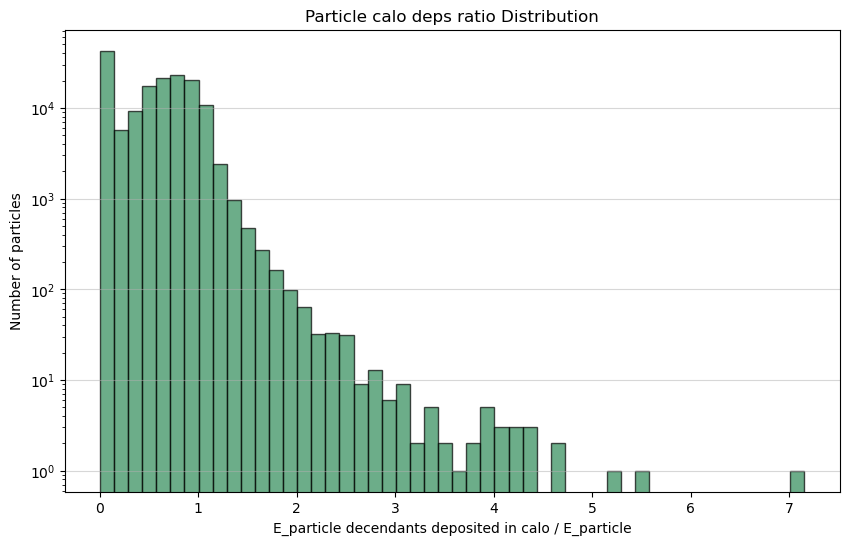

In [ ]:
from primary.preprocessing import particle_purity
p =particle_purity(calo_hits=calo_hits,ancestors=particles_with_lineage, particles=particles)
from primary.plot import plot_particle_purity
plot_particle_purity(calo_hits=calo_hits,ancestors=particles_with_lineage, particles=particles)

In [38]:
from primary.preprocessing import particle_purity_by_class
p =particle_purity_by_class(calo_hits=calo_hits,ancestors=particles_with_lineage, particles=particles, pdg_classes=pdg_classes)

In [41]:
p['pdg_id'].unique().to_list()

[-5324,
 -5314,
 -5232,
 -5224,
 -5222,
 -5214,
 -5212,
 -5132,
 -5122,
 -5114,
 -5112,
 -4322,
 -4232,
 -4224,
 -4214,
 -4212,
 -4132,
 -4122,
 -4114,
 -4112,
 -3334,
 -3324,
 -3322,
 -3314,
 -3312,
 -3224,
 -3222,
 -3214,
 -3212,
 -3122,
 -3114,
 -3112,
 -2224,
 -2214,
 -2212,
 -2114,
 -2112,
 -1114,
 -533,
 -531,
 -523,
 -521,
 -513,
 -511,
 -433,
 -431,
 -423,
 -421,
 -413,
 -411,
 -323,
 -321,
 -313,
 -311,
 -213,
 -211,
 -16,
 -15,
 -14,
 -13,
 -12,
 -11,
 11,
 12,
 13,
 14,
 15,
 16,
 22,
 111,
 113,
 211,
 213,
 221,
 223,
 311,
 313,
 321,
 323,
 331,
 333,
 411,
 413,
 421,
 423,
 431,
 433,
 511,
 513,
 521,
 523,
 531,
 533,
 1114,
 2112,
 2114,
 2212,
 2214,
 2224,
 3112,
 3114,
 3122,
 3212,
 3214,
 3222,
 3224,
 3312,
 3314,
 3322,
 3324,
 3334,
 4112,
 4114,
 4122,
 4132,
 4212,
 4214,
 4222,
 4224,
 4232,
 4314,
 5112,
 5114,
 5122,
 5132,
 5212,
 5214,
 5222,
 5224,
 5232,
 5312]

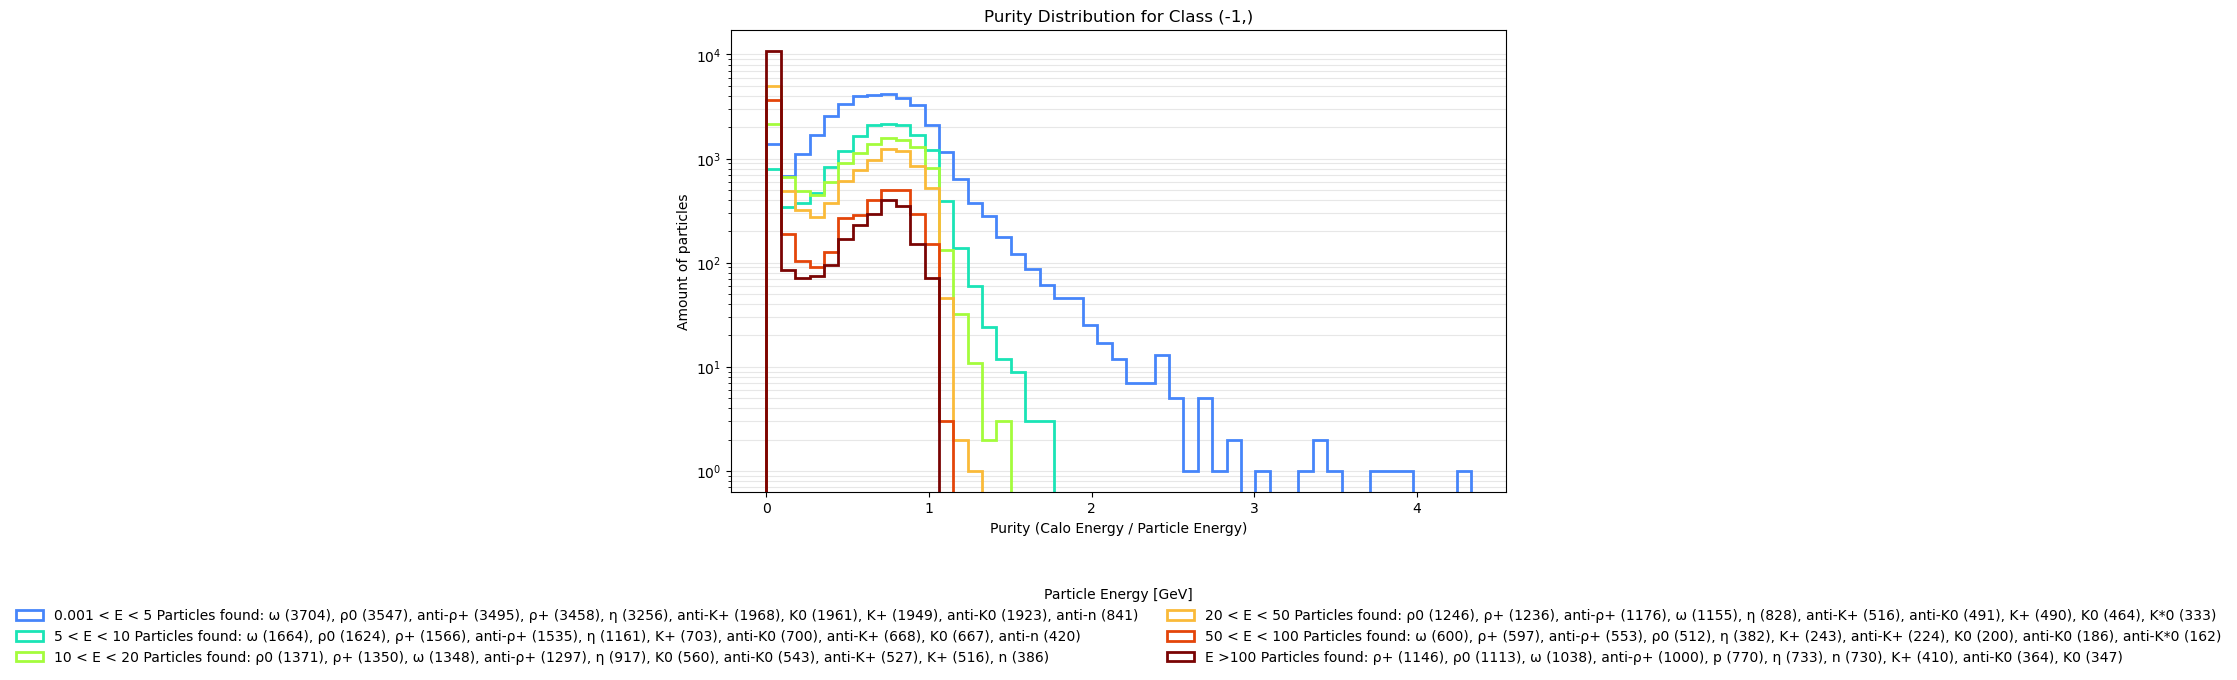

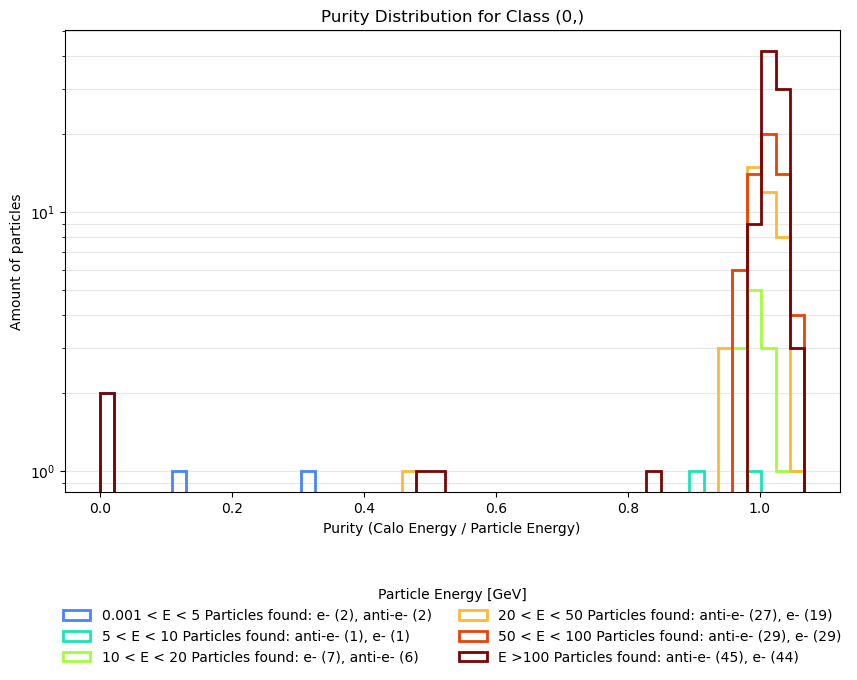

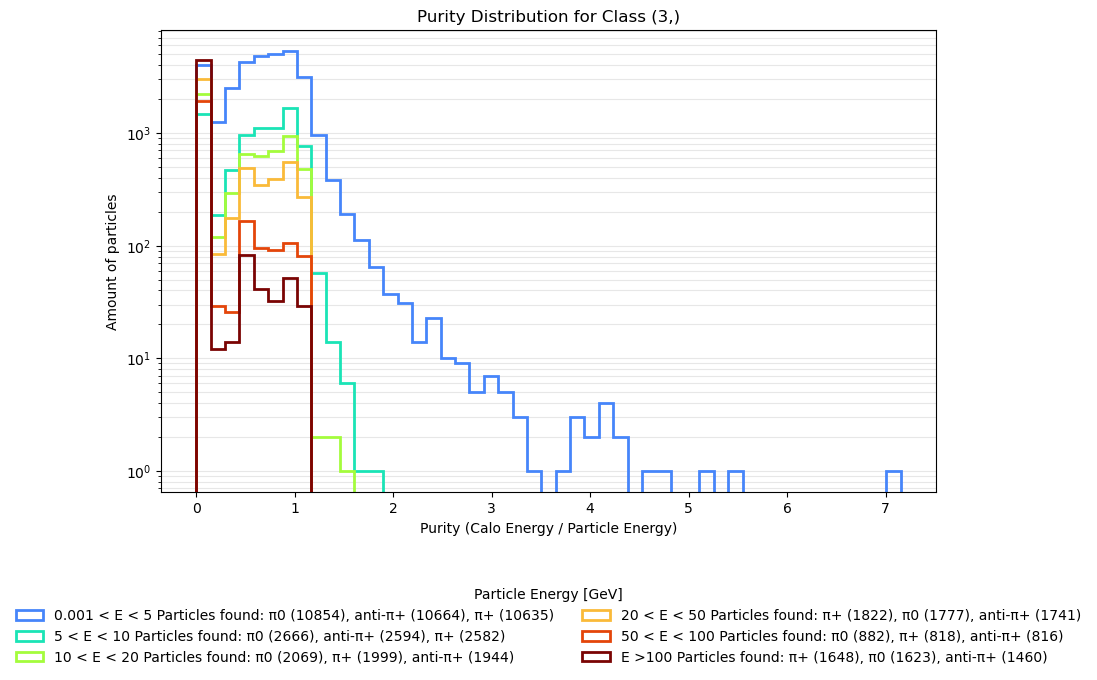

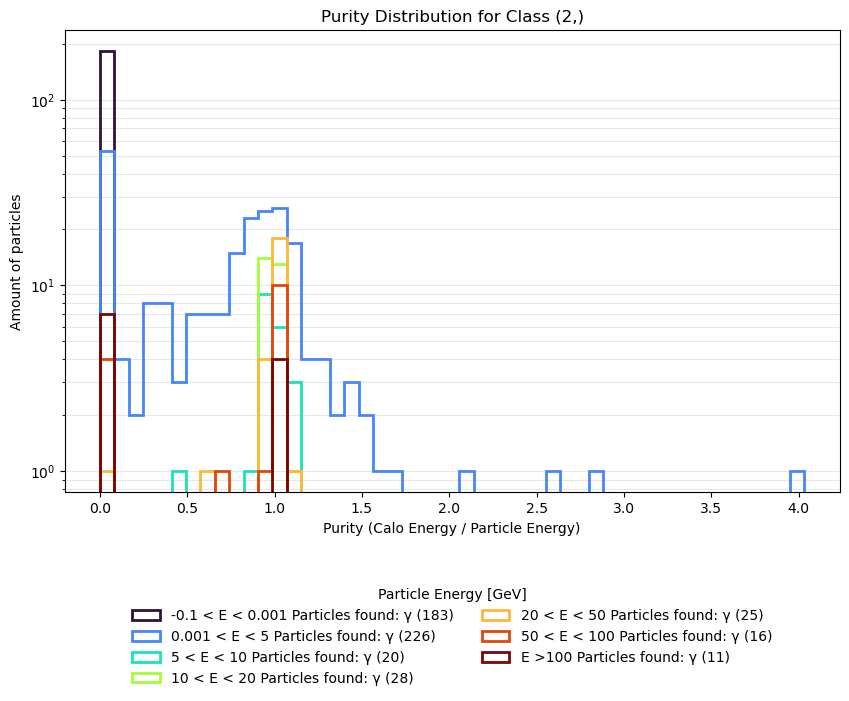

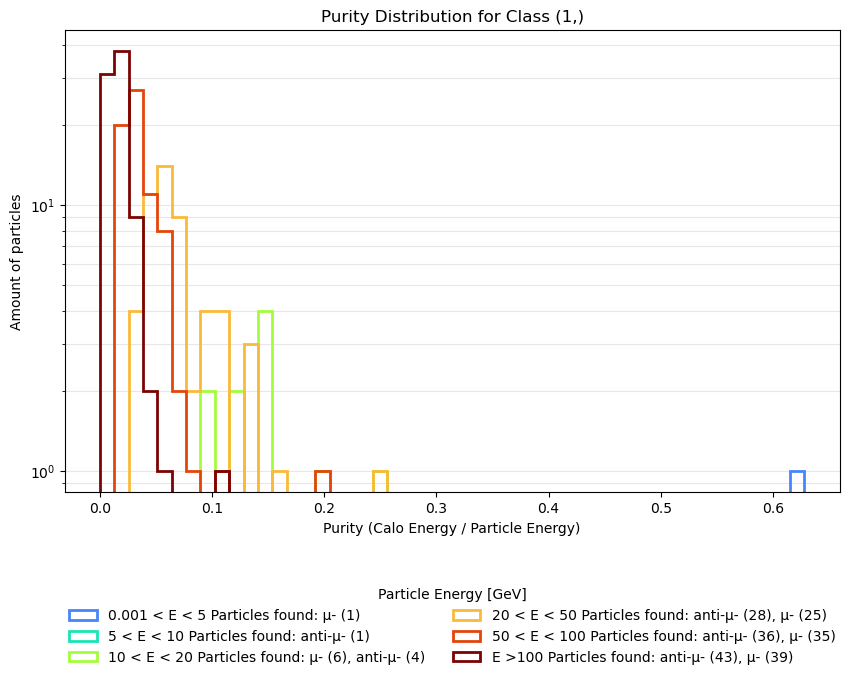

In [48]:
from primary.preprocessing import particle_purity_by_class
pdg_classes = [[11, -11],  # Electrons and Positrons
    [13, -13],  # Muons and Anti-Muons
    [22],      # Photons
    [211, -211, 111],# Charged Pions, neutral Pions
    [130, 310]] # Neutral Kaons

from primary.plot import plot_particle_purity_by_class
plot_particle_purity_by_class(calo_hits=calo_hits,ancestors=particles_with_lineage, particles=particles, pdg_classes=pdg_classes)


In [19]:
p_class['class_id'].unique()

class_id
i64
-1
0
1
2
3


In [17]:
pdg_classes = [[11, -11],  # Electrons and Positrons
    [13, -13],  # Muons and Anti-Muons
    [22],      # Photons
    [211, -211],# Charged Pions
    [130, 310]] # Neutral Kaons
pdg_classes_df = pl.DataFrame({
"class_id": list(range(len(pdg_classes))),
"pdg_ids": pdg_classes
})
(pdg_classes_df
            .explode('pdg_ids')
           .rename({'pdg_ids':'pdg_id'})
            )

class_id,pdg_id
i64,i64
0,11
0,-11
1,13
1,-13
2,22
3,211
3,-211
4,130
4,310


In [12]:
particles

event_id,is_target_particle,enter_calo,has_track,particle_id,pdg_id,mass,energy,charge,vx,vy,vz,time,px,py,pz,perigee_d0,perigee_z0,vertex_primary,parent_id,primary,is_parent_missing,created_inside_calo,eta,phi,pt
u32,list[bool],list[bool],list[bool],list[u64],list[i64],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[u16],list[i64],list[bool],list[bool],list[bool],list[f32],list[f32],list[f32]
250,"[false, false, … false]","[false, true, … false]","[false, false, … false]","[219, 220, … 7359]","[321, -311, … 211]","[0.49368, 0.49761, … 0.13957]","[510.153564, 525.826233, … 0.29946]","[1.0, 0.0, … 1.0]","[0.000895, 0.000895, … -179.946487]","[-0.018766, -0.018766, … 2169.664062]","[59.811329, 59.811329, … -211.217239]","[-0.325794, -0.325794, … 7.330573]","[-0.491808, -0.18692, … -0.203538]","[0.157237, -0.232051, … 0.066429]","[-510.153076, -525.825928, … 0.156064]","[NaN, 0.0, … -2006.760986]","[NaN, 0.0, … -826.59314]","[1, 1, … 1]","[9, 9, … 7358]","[true, true, … false]","[true, true, … false]","[false, false, … true]","[-7.588975, -8.168946, … 0.676194]","[2.832151, -2.248888, … 2.826122]","[0.516332, 0.297971, … 0.214104]"
122,"[false, false, … false]","[false, false, … true]","[false, false, … false]","[50, 51, … 3400]","[111, 2212, … 11]","[0.13498, 0.93827, … 0.000511]","[25.069691, 74.01371, … 0.001132]","[0.0, 1.0, … -1.0]","[-0.017536, -0.017536, … -247.586166]","[0.004952, 0.004952, … -613.687073]","[22.533466, 22.533466, … -293.825012]","[0.139495, 0.139495, … 2.600593]","[-1.21785, -2.679107, … 0.000539]","[0.949296, 2.117662, … 0.000854]","[25.021727, 73.928925, … -0.000035]","[0.006875, 0.00699, … NaN]","[22.26001, 22.169159, … NaN]","[1, 1, … 1]","[9, 9, … 3347]","[true, true, … false]","[true, true, … false]","[false, false, … false]","[3.479385, 3.768612, … -0.034641]","[2.479487, 2.472711, … 1.007645]","[1.544125, 3.414983, … 0.00101]"
521,"[false, false, … false]","[false, false, … true]","[false, false, … false]","[53, 54, … 3684]","[213, 311, … 11]","[0.797523, 0.49761, … 0.000511]","[30.020781, 7.325692, … 0.002558]","[1.0, 0.0, … -1.0]","[-0.014444, -0.014444, … 627.610291]","[0.00579, 0.00579, … 794.90979]","[-84.198357, -84.198357, … 772.325195]","[-0.031798, -0.031798, … 418.009369]","[0.084197, -0.010721, … -0.001935]","[0.059929, -0.73565, … -0.001335]","[30.010006, 7.271647, … 0.00087]","[NaN, -0.014526, … NaN]","[NaN, -84.143219, … NaN]","[1, 1, … 1]","[9, 9, … 735]","[true, true, … false]","[true, true, … false]","[false, false, … false]","[6.364339, 2.986574, … 0.362219]","[0.618582, -1.585369, … -2.537479]","[0.103348, 0.735728, … 0.002351]"
125,"[false, false, … false]","[false, true, … true]","[false, false, … false]","[153, 154, … 7275]","[-513, -211, … -11]","[5.3252, 0.13957, … 0.000511]","[58.829105, 10.205928, … 0.149274]","[0.0, -1.0, … 1.0]","[0.010811, 0.010811, … 1090.038208]","[0.023458, 0.023458, … -763.474731]","[-7.69766, -7.69766, … 155.094955]","[0.017386, 0.017386, … 4.560049]","[-46.987957, -8.540174, … 0.11924]","[34.917126, 5.534739, … -0.083961]","[2.330737, 0.757334, … -0.031857]","[-0.025277, -0.025565, … NaN]","[-7.697872, -7.697935, … NaN]","[1, 1, … 1]","[8, 8, … 7271]","[true, true, … false]","[true, true, … false]","[false, false, … false]","[0.039803, 0.074349, … -0.216745]","[2.502517, 2.566566, … -0.613496]","[58.541214, 10.176832, … 0.145834]"
917,"[true, false, … false]","[false, false, … false]","[false, false, … false]","[67, 68, … 4311]","[-521, 213, … -11]","[5.27925, 0.619832, … 0.000511]","[32.995766, 2.293803, … 0.162422]","[-1.0, 1.0, … 1.0]","[0.000291, 0.000291, … 351.036621]","[0.001928, 0.001928, … -163.553207]","[-17.349289, -17.349289, … 3995.422607]","[-0.046757, -0.046757, … 13.401054]","[-15.237241, -0.594791, … 0.011829]","[-19.46644, -0.554268, … -0.000618]","[21.206942, 2.053376, … 0.161989]","[-0.00096, -0.001212, … NaN]","[-17.347832, -17.345432, … NaN]","[1, 1

In [22]:
from primary.preprocessing import  CALIBRATION
(
    calo_hits.lazy()
    .select(["detector", "x", "y", "z"])
        .explode(["detector", "z", "y", "x"])

    .with_columns(
       (pl.col("x")*pl.col("x") + pl.col("y")*pl.col("y")).sqrt().alias("radius")
    )
    .group_by("detector")
    .agg(
        pl.col("z").mean().alias("z_mean"),
        pl.col("z").min().alias("z_min"),
        pl.col("z").max().alias("z_max"),
        pl.col("radius").mean().alias("radius_mean"),
        pl.col("radius").min().alias("radius_min"),
        pl.col("radius").max().alias("radius_max"),
    )
    .join(
        CALIBRATION.lazy().select(["detector", "system_label"])
        ,on="detector", how="inner"
        )
    .collect(streaming=True)
)

/tmp/ipykernel_883149/2472220820.py:23: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  .collect(streaming=True)


detector,z_mean,z_min,z_max,radius_mean,radius_min,radius_max,system_label
u8,f32,f32,f32,f32,f32,f32,str
12,-4224.70166,-5432.5,-3647.5,793.944214,362.489105,3426.650635,"""Hcal Endcap (Neg)"""
10,20.879986,-3049.800049,3049.800049,1343.255127,1252.399902,1518.832642,"""Ecal Barrel"""
13,21.076727,-3450.0,3450.0,1941.544556,1647.499878,3495.376465,"""Hcal Barrel"""
11,3306.225098,3202.399902,3439.75,737.25415,316.78894,1497.868652,"""Ecal Endcap (Pos)"""
9,-3306.426758,-3439.75,-3202.399902,736.191467,316.78894,1497.868652,"""Ecal Endcap (Neg)"""
14,4230.241699,3647.5,5432.5,791.89856,362.489105,3426.650391,"""Hcal Endcap (Pos)"""


In [14]:
calo_hits

event_id,detector,total_energy,x,y,z,contrib_particle_ids,contrib_energies,contrib_times
u32,list[u8],list[f32],list[f32],list[f32],list[f32],list[list[u64]],list[list[f32]],list[list[f32]]
0,"[14, 11, … 11]","[0.001968, 0.000626, … 0.000133]","[-319.95813, -180.72757, … -99.622643]","[-235.105301, -356.353302, … -307.14505]","[4514.5, 3242.800049, … 3252.899902]","[[1009, 1010, … 1046], [917, 915], … [976]]","[[0.000357, 0.000102, … 0.000504], [0.000476, 0.00015], … [0.000133]]","[[14.921773, 14.915427, … 14.947093], [10.852165, 10.768022], … [10.706934]]"
1,"[10, 9, … 10]","[0.00007, 0.000226, … 0.000199]","[-255.0, -200.717987, … 15.3]","[-1302.900024, -364.633606, … 1267.550049]","[-1836.0, -3374.100098, … -861.900024]","[[1144], [2867], … [2325]]","[[0.00007], [0.000226], … [0.000199]]","[[8.069325], [11.934299], … [5.520046]]"
2,"[9, 10, … 9]","[0.00016, 0.000609, … 0.000857]","[-624.59021, -1307.949951, … -1006.558716]","[319.435944, 127.5, … -847.883911]","[-3268.050049, 351.899994, … -3268.050049]","[[1666], [2966, 3018], … [2335]]","[[0.00016], [0.000538, 0.00007], … [0.000857]]","[[11.347424], [4.571045, 4.587587], … [12.148624]]"
3,"[11, 9, … 10]","[0.000141, 0.000435, … 0.000653]","[296.96283, 173.399994, … -777.393188]","[-490.373688, -887.988953, … -993.767883]","[3313.5, -3303.399902, … 2861.100098]","[[3360], [656], … [1317]]","[[0.000141], [0.000435], … [0.000653]]","[[11.276829], [11.554907], … [10.170697]]"
4,"[11, 10, … 10]","[0.000199, 0.000092, … 0.000146]","[-243.458908, 1101.495605, … 1234.614624]","[-374.530731, -762.508606, … 384.429535]","[3242.800049, 1116.900024, … 2529.600098]","[[1876], [2192], … [1957]]","[[0.000199], [0.000092], … [0.000146]]","[[12.287476], [5.514093], … [9.358251]]"
…,…,…,…,…,…,…,…,…
995,"[10, 9, … 10]","[0.000179, 0.000755, … 0.002765]","[1240.377441, 251.265656, … -1015.369995]","[-436.498352, -393.377869, … 762.932861]","[923.099976, -3283.199951, … -2009.400024]","[[2253], [3423], … [4697, 4699, 4696]]","[[0.000179], [0.000755], … [0.000426, 0.000578, 0.001761]]","[[5.130617], [10.436249], … [7.334979, 7.338215, 7.337309]]"
996,"[9, 9, … 9]","[0.001676, 0.000216, … 0.001685]","[153.403976, 231.21611, … 494.277039]","[290.388306, 252.853577, … 287.539246]","[-3364.0, -3374.100098, … -3278.149902]","[[3716], [4874, 4899], … [3983, 3981, … 3987]]","[[0.001676], [0.00003, 0.000187], … [0.000137, 0.000351, … 0.00073]]","[[12.006806], [11.732627, 11.585358], … [11.363146, 11.363526, … 11.363279]]"
997,"[11, 11, … 12]","[0.000172, 0.002722, … 0.000511]","[-590.129578, -251.657959, … -1352.489136]","[349.323486, -580.902161, … 180.0]","[3313.5, 3298.350098, … -3851.5]","[[7933], [3159, 4558, … 6124], … [6785]]","[[0.000172], [0.000129, 0.000042, … 0.001454], … [0.000511]]","[[11.654412], [11.277998, 11.386529, … 11.263212], … [14.255626]]"


In [59]:
from primary.plot import plot_3d_particle_hierarchy
import plotly.io as pio
# This forces Plotly to embed the JS data directly in the cell output
# which helps it survive the SSH transfer to your local screen.
#pio.renderers.default = "notebook"
plot_3d_particle_hierarchy(particles=particles, calo_hits=calo_hits, event_idx=5)

In [10]:
energy_fraction = (
    particles.lazy()
    .select("event_id", "is_parent_missing", "energy")
    .explode(["is_parent_missing", "energy"])
    .filter(pl.col("is_parent_missing"))
    .group_by("event_id")
    .agg(pl.col("energy").sum().alias("total_energy"))
    .join(
        calo_hits.lazy()
        .select("event_id", "total_energy")
        .explode("total_energy")
        .group_by("event_id")
        .agg(pl.col("total_energy").sum().alias("calo_total_energy")),
        on="event_id",
        how="inner",
    )
    .with_columns(
        (pl.col("calo_total_energy") / pl.col("total_energy")).alias("energy_fraction")
    )
    .collect(streaming=True)
)

/tmp/ipykernel_1110088/1101888204.py:20: DeprecationWarning:

the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.



In [ ]:
# ...existing code...
cell_residuals = (
    calo_hits.lazy()
    .filter(pl.col("event_id")<4)
    .select("event_id", "total_energy", "contrib_energies")
    .with_columns(
        pl.col("contrib_energies")
        .list.eval(pl.element().list.sum())
        .alias("contrib_energy_sum")
    )
    .explode(["total_energy", "contrib_energy_sum"])
    .with_columns(
        (pl.col("total_energy") - pl.col("contrib_energy_sum")).alias("energy_residual"),
    )
    .select("event_id", "total_energy", "contrib_energy_sum", "energy_residual")
    .collect(streaming=True)
)
# ...existing code...

/tmp/ipykernel_1354137/2797988344.py:15: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  .collect(streaming=True)


: 

In [21]:
calo_hits

event_id,detector,total_energy,x,y,z,contrib_particle_ids,contrib_energies,contrib_times
u32,list[u8],list[f32],list[f32],list[f32],list[f32],list[list[u64]],list[list[f32]],list[list[f32]]
0,"[14, 11, … 11]","[0.001968, 0.000626, … 0.000133]","[-319.95813, -180.72757, … -99.622643]","[-235.105301, -356.353302, … -307.14505]","[4514.5, 3242.800049, … 3252.899902]","[[1009, 1010, … 1046], [917, 915], … [976]]","[[0.000357, 0.000102, … 0.000504], [0.000476, 0.00015], … [0.000133]]","[[14.921773, 14.915427, … 14.947093], [10.852165, 10.768022], … [10.706934]]"
1,"[10, 9, … 10]","[0.00007, 0.000226, … 0.000199]","[-255.0, -200.717987, … 15.3]","[-1302.900024, -364.633606, … 1267.550049]","[-1836.0, -3374.100098, … -861.900024]","[[1144], [2867], … [2325]]","[[0.00007], [0.000226], … [0.000199]]","[[8.069325], [11.934299], … [5.520046]]"
2,"[9, 10, … 9]","[0.00016, 0.000609, … 0.000857]","[-624.59021, -1307.949951, … -1006.558716]","[319.435944, 127.5, … -847.883911]","[-3268.050049, 351.899994, … -3268.050049]","[[1666], [2966, 3018], … [2335]]","[[0.00016], [0.000538, 0.00007], … [0.000857]]","[[11.347424], [4.571045, 4.587587], … [12.148624]]"
3,"[11, 9, … 10]","[0.000141, 0.000435, … 0.000653]","[296.96283, 173.399994, … -777.393188]","[-490.373688, -887.988953, … -993.767883]","[3313.5, -3303.399902, … 2861.100098]","[[3360], [656], … [1317]]","[[0.000141], [0.000435], … [0.000653]]","[[11.276829], [11.554907], … [10.170697]]"
4,"[11, 10, … 10]","[0.000199, 0.000092, … 0.000146]","[-243.458908, 1101.495605, … 1234.614624]","[-374.530731, -762.508606, … 384.429535]","[3242.800049, 1116.900024, … 2529.600098]","[[1876], [2192], … [1957]]","[[0.000199], [0.000092], … [0.000146]]","[[12.287476], [5.514093], … [9.358251]]"
…,…,…,…,…,…,…,…,…
995,"[10, 9, … 10]","[0.000179, 0.000755, … 0.002765]","[1240.377441, 251.265656, … -1015.369995]","[-436.498352, -393.377869, … 762.932861]","[923.099976, -3283.199951, … -2009.400024]","[[2253], [3423], … [4697, 4699, 4696]]","[[0.000179], [0.000755], … [0.000426, 0.000578, 0.001761]]","[[5.130617], [10.436249], … [7.334979, 7.338215, 7.337309]]"
996,"[9, 9, … 9]","[0.001676, 0.000216, … 0.001685]","[153.403976, 231.21611, … 494.277039]","[290.388306, 252.853577, … 287.539246]","[-3364.0, -3374.100098, … -3278.149902]","[[3716], [4874, 4899], … [3983, 3981, … 3987]]","[[0.001676], [0.00003, 0.000187], … [0.000137, 0.000351, … 0.00073]]","[[12.006806], [11.732627, 11.585358], … [11.363146, 11.363526, … 11.363279]]"
997,"[11, 11, … 12]","[0.000172, 0.002722, … 0.000511]","[-590.129578, -251.657959, … -1352.489136]","[349.323486, -580.902161, … 180.0]","[3313.5, 3298.350098, … -3851.5]","[[7933], [3159, 4558, … 6124], … [6785]]","[[0.000172], [0.000129, 0.000042, … 0.001454], … [0.000511]]","[[11.654412], [11.277998, 11.386529, … 11.263212], … [14.255626]]"


In [14]:
(
    calo_hits.lazy()
    .select("event_id", "total_energy", 'contrib_energies'
            .explode('total_energy', 'contrib_energies')
            
            )
)

event_id,total_energy,calo_total_energy,energy_fraction
u32,f32,f32,f32
642,13999.999023,29.229231,0.002088
824,14000.005859,43.455753,0.003104
660,14000.003906,13.691787,0.000978
943,14000.00293,18.902807,0.00135
896,14000.0,28.783998,0.002056
…,…,…,…
45,14000.0,22.67457,0.00162
578,14000.004883,25.423943,0.001816
33,13999.99707,25.775154,0.001841


/tmp/ipykernel_1110088/1390836840.py:6: DeprecationWarning:

the `zero_copy_only` parameter for `Series.to_numpy` is deprecated. Use the `allow_copy` parameter instead, which is the inverse of `zero_copy_only`.
(Deprecated in version 0.20.10)



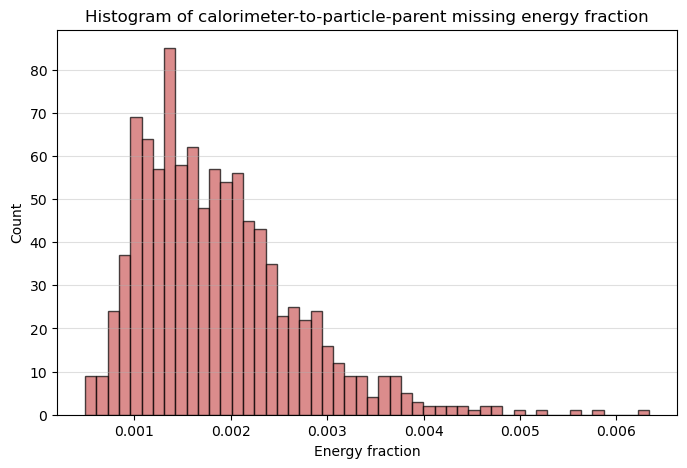

In [15]:
# ...existing code...
fractions = (
    energy_fraction
    .select("energy_fraction")
    .to_series()
    .to_numpy(zero_copy_only=False)
)

plt.figure(figsize=(8, 5))
plt.hist(fractions, bins=50, color="indianred", edgecolor="black", alpha=0.7)
plt.xlabel("Energy fraction")
plt.ylabel("Count")
plt.title("Histogram of calorimeter-to-particle-parent missing energy fraction")
plt.grid(axis="y", alpha=0.4)
plt.show()
# ...existing code...

In [ ]:
with pl.Config(tbl_rows=-1):

    print(
        particles.lazy()
        .select('primary', 'is_parent_missing', 'pdg_id')
        .explode(['primary', 'is_parent_missing', 'pdg_id'])
        .filter((pl.col('primary') & ~pl.col('is_parent_missing')))
        .select('pdg_id')
        .group_by('pdg_id')
        .len()
        .sort('len', descending=True)
        .head(10)
        .collect()  
    )

shape: (10, 2)
┌────────┬───────┐
│ pdg_id ┆ len   │
│ ---    ┆ ---   │
│ i64    ┆ u32   │
╞════════╪═══════╡
│ 111    ┆ 55591 │
│ 211    ┆ 47254 │
│ -211   ┆ 46884 │
│ 22     ┆ 11389 │
│ 310    ┆ 7850  │
│ 130    ┆ 7554  │
│ 321    ┆ 3845  │
│ -321   ┆ 3772  │
│ -311   ┆ 3200  │
│ 311    ┆ 3184  │
└────────┴───────┘


In [24]:
with pl.Config(tbl_rows=-1):
    print(
        particles.lazy()
        .select('primary','event_id', 'is_parent_missing', 'pdg_id', 'parent_id') # this is A
        .explode(['primary', 'is_parent_missing', 'pdg_id', 'parent_id'])
        .filter((pl.col('primary') & ~pl.col('is_parent_missing')))
        .select('pdg_id','event_id', 'parent_id')
        .join(
                (
                    particles.lazy()
                    .select('particle_id', 'pdg_id', 'event_id')
                    .rename({'particle_id': 'particle_id', 'pdg_id': 'parent_pdg_id', 'event_id': 'event_id'})
                    .explode('particle_id', 'parent_pdg_id')),
            left_on=['parent_id', 'event_id'],
            right_on=['particle_id', 'event_id'],
            how='left',
        )

        .group_by('pdg_id', 'parent_pdg_id')
        .len()
        .sort('len', descending=True)
        .head(20)
        .collect()  
    )

shape: (20, 3)
┌────────┬───────────────┬───────┐
│ pdg_id ┆ parent_pdg_id ┆ len   │
│ ---    ┆ ---           ┆ ---   │
│ i64    ┆ i64           ┆ u32   │
╞════════╪═══════════════╪═══════╡
│ 111    ┆ 221           ┆ 10306 │
│ -211   ┆ 113           ┆ 10162 │
│ 211    ┆ 113           ┆ 10162 │
│ 211    ┆ 213           ┆ 9864  │
│ 111    ┆ 213           ┆ 9853  │
│ 111    ┆ 223           ┆ 9782  │
│ -211   ┆ -213          ┆ 9593  │
│ 111    ┆ -213          ┆ 9591  │
│ 211    ┆ 223           ┆ 9096  │
│ -211   ┆ 223           ┆ 9096  │
│ 22     ┆ 221           ┆ 7142  │
│ 211    ┆ 310           ┆ 5414  │
│ -211   ┆ 310           ┆ 5414  │
│ 111    ┆ 310           ┆ 4868  │
│ 310    ┆ -311          ┆ 3790  │
│ 310    ┆ 311           ┆ 3755  │
│ 130    ┆ 311           ┆ 3628  │
│ 130    ┆ -311          ┆ 3617  │
│ -211   ┆ 221           ┆ 2384  │
│ 211    ┆ 221           ┆ 2384  │
└────────┴───────────────┴───────┘


In [5]:
from primary.preprocessing import map_to_ultimate_ancestor_with_inherited_mask
particles_with_lineage = map_to_ultimate_ancestor_with_inherited_mask(particles)


Preparing data & calculating masks...
Converged after 5 iterations.


In [6]:
from primary.preprocessing import particle_purity
particles_with_purity = particle_purity(calo_hits=calo_hits,ancestors=particles_with_lineage, particles=particles)
particles_with_purity

event_id,ultimate_ancestor_id,total_energy_in_calo,total_particle_energy,purity
u32,i64,f32,f32,f32
640,328,0.020479,0.930543,0.022008
640,343,0.192252,8.651638,0.022221
640,546,0.075578,7.356803,0.010273
640,554,0.073349,3.704378,0.019801
641,207,0.010703,1.119498,0.009561
…,…,…,…,…
831,943,0.109881,5.762229,0.019069
831,963,0.238694,8.525401,0.027998
831,1030,1.918916,76.551346,0.025067


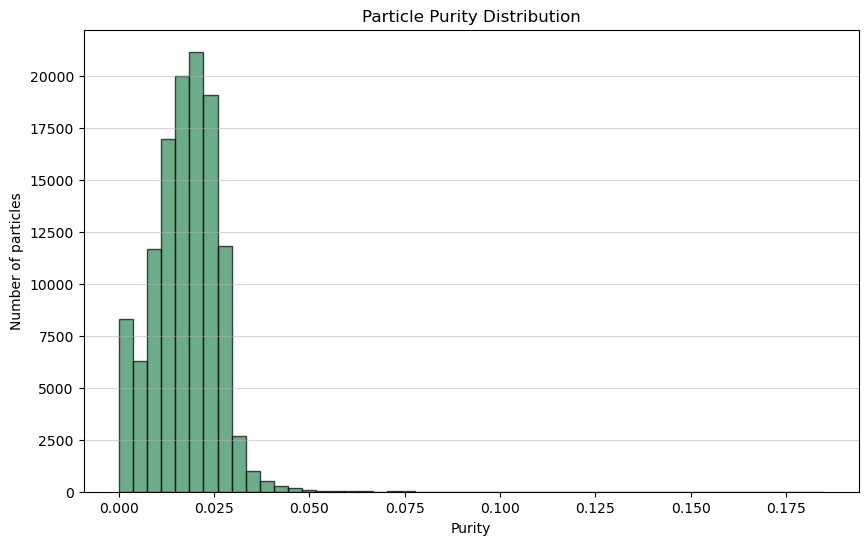

In [19]:
from primary.plot import plot_particle_purity
plot_particle_purity(calo_hits=calo_hits,ancestors=particles_with_lineage, particles=particles)

Processing first 100 events for histogram...


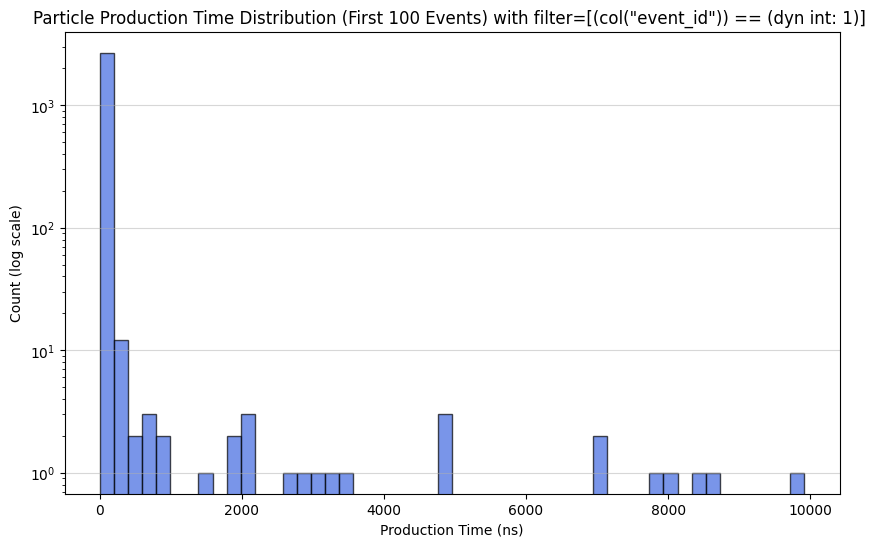

Total particles plotted: 2719
Mean time: 47.4903 ns
Max time:  9918.4180 ns


In [4]:
import polars as pl

from primary.plot import plot_production_time_histogram
plot_production_time_histogram(particles, n_events=100, bins=50, log_scale=True, filter_expression=pl.col("event_id") == 1)#

In [7]:
from primary.plot import plot_ancestor_distribution
plot_ancestor_distribution(particles_with_lineage)

ModuleNotFoundError: No module named 'plotly.io'

In [29]:
(
particles.lazy()
.select('event_id','particle_id')
.explode('particle_id')
.join(
    particles_with_lineage.lazy().select('event_idx','ultimate_ancestor_id').unique(),
    left_on=["event_id", "particle_id"], 
    right_on=["event_idx", "ultimate_ancestor_id"],
    how="inner",
)
.unique()
.collect()
)



event_id,particle_id
u32,u64


In [75]:
event_idx = 7
from primary.preprocessing import run_meanshift
calo_event_with_clusters = run_meanshift(event_idx, calo_hits, bandwidth=500)
# cluster count
cluster_count = calo_event_with_clusters.select("cluster_id").explode('cluster_id').n_unique()
print(f"Event {event_idx} has {cluster_count} clusters identified by MeanShift.")

Event 7 has 51 clusters identified by MeanShift.


In [56]:
calo_event_with_clusters

event_id,detector,total_energy,x,y,z,contrib_particle_ids,contrib_energies,contrib_times,cluster_id,cluster_cx,cluster_cy,cluster_cz
u32,list[u8],list[f32],list[f32],list[f32],list[f32],list[list[u64]],list[list[f32]],list[list[f32]],"array[i32, 12553]","array[f32, 12553]","array[f32, 12553]","array[f32, 12553]"
4,"[11, 10, … 10]","[0.000199, 0.000092, … 0.000146]","[-243.458908, 1101.495605, … 1234.614624]","[-374.530731, -762.508606, … 384.429535]","[3242.800049, 1116.900024, … 2529.600098]","[[1876], [2192], … [1957]]","[[0.000199], [0.000092], … [0.000146]]","[[12.287476], [5.514093], … [9.358251]]","[0, 0, … 0]","[335.154724, 335.154724, … 335.154724]","[306.335144, 306.335144, … 306.335144]","[1244.026855, 1244.026855, … 1244.026855]"


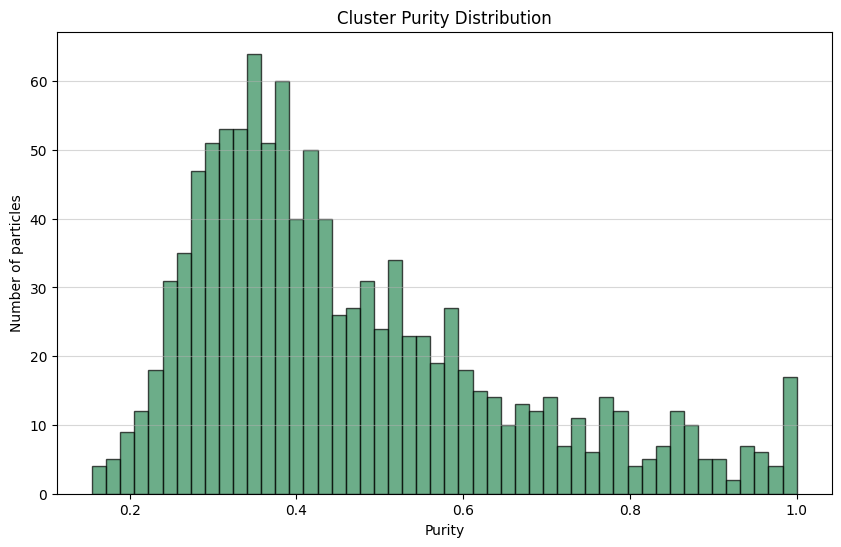

In [76]:
from primary.plot import plot_purity
plot_purity(calo_event_with_clusters, particles_with_lineage)

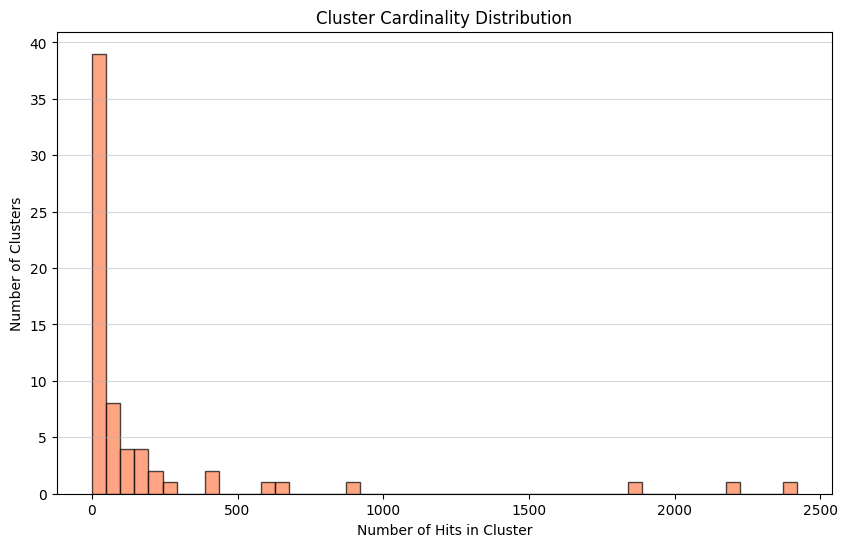

In [70]:
from primary.plot import plot_cluster_cardinallity
plot_cluster_cardinallity(calo_event_with_clusters)

In [ ]:
memory_datasets['OpenDataDetector/ColliderML_ttbar_pu0']['particles']['train'][5]

parent_id
list[f64]
"[9.0, 9.0, … null]"


In [7]:
particle_ids = particles[5]['particle_id'][0]
parent_ids = particles[5]['parent_id'][0]
particles_time = particles[5]['time'][0]
index = (particle_ids == 1150).arg_true().to_list()[0]
print(index)
parent_exact_id = parent_ids[index] 
particle_time = particles_time[index]
print(parent_exact_id)
parent_index = (particle_ids == parent_exact_id).arg_true().to_list()[0]
parent_time = particles_time[parent_index]
print(parent_index)
parent_parent_id = parent_ids[parent_index]
print(parent_parent_id)
print(f"Summary: Particle {particle_ids[index]}, index: {index}, creation time: {particle_time} has parent {parent_exact_id}, parent_index: {parent_index}, parent creation time: {parent_time} whose parent is {parent_parent_id}")

493
1153.0
496
1150.0
Summary: Particle 1150, index: 493, creation time: 2.123812437057495 has parent 1153.0, parent_index: 496, parent creation time: 4.163594722747803 whose parent is 1150.0


In [17]:
import polars as pl
exploded = particles.head(10).explode([ "particle_id"])
# select particle_id,event_id
result = (
    exploded.select(["event_id", "particle_id"])
)
result

event_id,particle_id
i64,i64
0,76
0,77
0,78
0,79
0,80
…,…
9,6966
9,6967
9,6968


In [16]:
import polars as pl
exploded = particles.head(10).explode([ "particle_id"])
result = (
    exploded.group_by(["event_id", "particle_id"])
            .agg(pl.len().alias("count"))
          
)
result

event_id,particle_id,count
i64,i64,u32
1,2399,1
0,964,1
8,2672,1
7,6269,1
7,2721,1
…,…,…
6,5374,1
5,5216,1
6,1817,1


In [14]:
particles

event_id,particle_id,pdg_id,mass,energy,charge,vx,vy,vz,time,px,py,pz,vertex_primary,parent_id,is_parent_missing
i64,list[i64],list[i64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[i64],list[i64],list[bool]
0,"[76, 77, … 1977]","[213, -211, … 2212]","[0.738762, 0.13957, … 0.938272]","[2491.611858, 489.56621, … 1.464839]","[1.0, -1.0, … 1.0]","[0.009162, 0.009162, … 2159.469482]","[-0.003694, -0.003694, … 1843.329346]","[196.070236, 196.070236, … -210.282364]","[11.958187, 11.958187, … 22.085659]","[0.033283, -0.342658, … 0.853529]","[-0.117263, 0.317618, … 0.710063]","[2491.611816, 489.565979, … 0.180822]","[1, 1, … 1]","[9, 9, … 1976]","[true, true, … false]"
1,"[10, 11, … 2692]","[211, -211, … 22]","[0.13957, 0.13957, … 0.0]","[1935.443866, 28.814048, … 222.092745]","[1.0, -1.0, … 0.0]","[-0.023709, -0.023709, … -0.023614]","[0.010315, 0.010315, … 0.010545]","[106.12365, 106.12365, … 106.042526]","[4.075578, 4.075578, … 4.075848]","[-0.005252, 0.212135, … 0.30518]","[0.20687, -0.101696, … 0.58315]","[1935.443848, 28.81275, … -222.091766]","[1, 1, … 1]","[3, 3, … 80]","[true, true, … false]"
2,"[64, 65, … 3226]","[-523, 111, … -11]","[5.3252, 0.13498, … 0.000511]","[18.453095, 3.594066, … 0.362266]","[0.0, 0.0, … 1.0]","[-0.013339, -0.013339, … 16.921406]","[-0.005375, -0.005375, … 1308.693481]","[49.383862, 49.383862, … -1014.986938]","[0.945178, 0.945178, … 6.572384]","[17.1297, 3.394495, … 0.009029]","[-2.952355, -0.652638, … 0.275271]","[3.164794, 0.974962, … -0.235331]","[1, 1, … 1]","[9, 9, … 3213]","[true, true, … false]"
3,"[43, 44, … 4354]","[2212, 221, … 22]","[0.93827, 0.54785, … 0.0]","[22.615156, 25.405206, … 2.882969]","[1.0, 0.0, … 0.0]","[0.008929, 0.008929, … 0.008919]","[-0.012789, -0.012789, … -0.012751]","[61.058159, 61.058159, … 61.060184]","[-2.133011, -2.133011, … -2.133004]","[0.010547, -0.045738, … -0.013601]","[0.230913, 0.842978, … 0.074248]","[22.594501, 25.385263, … 2.881981]","[1, 1, … 1]","[8, 8, … 136]","[true, true, … false]"
4,"[113, 114, … 2269]","[223, 211, … 11]","[0.780666, 0.13957, … 0.000511]","[144.329089, 1.095027, … 0.139602]","[0.0, 1.0, … -1.0]","[0.006297, 0.006297, … 789.904236]","[0.01418, 0.01418, … -1050.674683]","[52.569878, 52.569878, … 1126.600952]","[-7.506285, -7.506285, … -1.779469]","[-0.278494, 0.021264, … 0.017909]","[0.013545, 0.021074, … -0.108077]","[144.326706, 1.085683, … 0.086528]","[1, 1, … 1]","[8, 8, … 2263]","[true, true, … false]"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
995,"[80, 81, … 5640]","[-321, 223, … 11]","[0.49368, 0.793777, … 0.000511]","[28.717168, 8.620346, … 0.000618]","[-1.0, 0.0, … -1.0]","[-0.006419, -0.006419, … 657.985657]","[-0.011553, -0.011553, … -44.434826]","[-75.322754, -75.322754, … -896.249573]","[-10.286097, -10.286097, … 0.747436]","[-11.782568, -3.758275, … 0.000138]","[6.858037, 2.032827, … -0.000308]","[-25.269951, -7.44468, … -0.000084]","[1, 1, … 1]","[9, 9, … 5639]","[true, true, … false]"
996,"[29, 30, … 6055]","[-211, 111, … 211]","[0.13957, 0.13498, … 0.1395701]","[1.356178, 0.223959, … 0.394234]","[-1.0, 0.0, … 1.0]","[-0.000957, -0.000957, … 764.739319]","[0.005772, 0.005772, … -1481.490234]","[-1.210217, -1.210217, … -1178.932739]","[6.712732, 6.712732, … 13.60649]","[-0.174356, 0.102382, … -0.072125]","[0.433903, -0.041758, … -0.34707]","[1.265332, 0.1404, … -0.101396]","[1, 1, … 1]","[9, 9, … 6054]","[true, true, … false]"
997,"[145, 146, … 7849]","[221, 111, … 11]","[0.54785, 0.13498, … 0.000511]","[2.467179, 0.135171, … 0.000517]","[0.0, 0.0, … -1.0]","[0.009254, 0.009254, … 428.086304]","[-0.000325, -0.000325, … -501.950165]","[86.061668, 86.061668, … 1074.772827]","[8.644897, 8.644897, … 20.044153]","[1.394695, -0.006932, … -0.000056]","[0.625924, 0.001811, … 0.000044]","[1.857385, 0.000576, … -0.000033]","[1, 1, … 1]","[8, 8, … 7842]","[true, true, … false]"


In [ ]:
import pandas as pd

def get_ancestors_with_cycle_detection(ids, parent_ids):
    # 1. Fast lookup map
    parent_map = dict(zip(ids, parent_ids))
    
    # 2. Memoization dictionary to store final root for every ID
    #    If a node is part of a cycle, we map it to None (or a specific flag)
    #    to prevent infinite loops in future lookups.
    ancestors = {}

    for node in ids:
        # If already calculated, skip
        if node in ancestors:
            continue

        path = []
        path_set = set() # For O(1) cycle checking
        curr = node
        
        root_found = None
        
        while True:
            # Add current node to path
            path.append(curr)
            path_set.add(curr)
            
            # Get parent
            parent = parent_map.get(curr)

            # --- END CONDITION 1: Natural Root (None) ---
            if parent is None:
                root_found = curr
                break
            
            # --- END CONDITION 2: Self-Loop ---
            if parent == curr:
                # Technically a cycle, usually treated as a root in this context
                root_found = curr
                break

            # --- END CONDITION 3: Hit a previously calculated node ---
            if parent in ancestors:
                root_found = ancestors[parent]
                break

            # --- END CONDITION 4: Cycle Detected (Loop) ---
            if parent in path_set:
                # We found a cycle. 
                # Let's extract exactly which nodes are looping.
                cycle_start_index = path.index(parent)
                cycle_nodes = path[cycle_start_index:]
                
                # Print the cycle
                print(f"Cycle Detected: {' -> '.join(map(str, cycle_nodes))} -> {parent}")
                
                # We define the 'root' of a cycle as None (or you could mark it as "Cycle")
                root_found = None 
                break
            
            # Move up
            curr = parent
        
        # --- Path Compression ---
        # Assign the found result to everyone in the path so we never process them again.
        for p in path:
            ancestors[p] = root_found

    return ancestors

# Usage
df = pd.DataFrame({'id': particles[5]['particle_id'][0].to_list(), 'parent_id': particles[5]['parent_id'][0].to_list()})
df['root_id'] = get_ancestors_with_cycle_detection(df['id'], df['parent_id'])
print(df)

Cycle Detected: 1150.0 -> 1153.0 -> 1150.0
Cycle Detected: 1160 -> 1161.0 -> 1160.0
Cycle Detected: 1228.0 -> 1230.0 -> 1228.0
Cycle Detected: 1259.0 -> 1262.0 -> 1259.0
Cycle Detected: 1268.0 -> 1265.0 -> 1268.0
Cycle Detected: 1325.0 -> 1322.0 -> 1325.0
Cycle Detected: 1359.0 -> 1361.0 -> 1359.0
Cycle Detected: 1460.0 -> 1461.0 -> 1460.0
Cycle Detected: 1481.0 -> 1484.0 -> 1487.0 -> 1490.0 -> 1480.0 -> 1481.0
Cycle Detected: 1587.0 -> 1586.0 -> 1587.0
Cycle Detected: 1602.0 -> 1605.0 -> 1602.0
Cycle Detected: 1627.0 -> 1630.0 -> 1627.0
Cycle Detected: 1728.0 -> 1727.0 -> 1728.0
Cycle Detected: 1740.0 -> 1739.0 -> 1740.0
Cycle Detected: 1767.0 -> 1770.0 -> 1766.0 -> 1769.0 -> 1768.0 -> 1771.0 -> 1765.0 -> 1767.0
Cycle Detected: 1803.0 -> 1806.0 -> 1803.0
Cycle Detected: 1889.0 -> 1888.0 -> 1889.0
Cycle Detected: 1900.0 -> 1899.0 -> 1901.0 -> 1898.0 -> 1900.0
Cycle Detected: 1921.0 -> 1922.0 -> 1921.0
Cycle Detected: 1957 -> 1960.0 -> 1957.0
Cycle Detected: 1985.0 -> 1988.0 -> 1985.0
C

ValueError: cannot reindex on an axis with duplicate labels